In [1]:
# Import libraries to use 
import numpy as np
import matplotlib.pyplot as plt
import math       
import scipy as sp
import scipy.optimize
import subprocess # Library to run ngspice on shell
import seaborn as sns # Library to change the color palette for plots
import random
import timeit # To time computing time
import warnings # To supress warnings
import string

In [2]:
def readdata(filename,Labels,Data_points):
    out = subprocess.run(['ngspice', '-b', filename], 
                         stdout=subprocess.PIPE,  stderr=subprocess.PIPE)
    
    name = filename[:-4]+'.txt' # Name of the file to save output from ngspice
    
    # This saves output data in txt file
    with open(name, 'w') as output:
        for line in out.stdout.decode('ascii').split('\n'):
            output.write(line+'\n') # Writing output lines 
    
    # We get the data into an array 
    fill = np.zeros (len(Labels), dtype=int)
    
    f = open (name, 'r');
    src = []
    while True:  
        line = f.readline()
        if not line: break  # end of file
        if line[0] == '#':
            continue # treat next line
        src.append(line)

    #print(src)
    data = np.zeros ([Data_points, len(Labels)])

    for line in src:
        #print line
        # Here we initialize the ngspice data array
        '''
        if line.startswith('No.'):
            temp_list = line.split(":")
            Data_points = int(temp_list[-1])
            #print(Data_points)
            data = np.zeros ([Data_points, len(Labels)])
            #print(data.shape)
        '''
        
        
        # Here we determine the indexes for the current columns
        if line.startswith('Index'):
            temp_list = [str(x) for x in line.split()]
            #print(temp_list)
            n_columns = len (temp_list)
            index = np.zeros(n_columns, dtype = int)

            for j in range(n_columns):
                index [j] = Labels.index(temp_list[j])
            #print index

        # if the line starts with a number, we treat it as the data line
        if line[0].isdigit():
            temp_data = [float(x) for x in line.split()]

            for c in range(n_columns):
                r = fill[c]
                #print(r, index [c])

                data [r][index[c]] = temp_data [c]

                fill [c] = fill [c] + 1
                if fill [c] == Data_points:
                    fill [c] = 0
    return data

In [3]:
# Fitting model including resistance 
def model_func(I,Rt,Ic,n):
    V0 = 100E-6 # Considering the criterion 100uV/m with length = 1 m
    return Rt*I+V0*(I/Ic)**n

def fit_exp(I,V,Rt0,Ic0,n0): #(Rt0,Ic0,n0) are guessed initial values 
    opt_parms, parm_cov = sp.optimize.curve_fit(model_func, I, V,(Rt0,Ic0,n0))
    Rt,Ic,n = opt_parms
    return Rt,Ic,n

# CORC model for 2 layers of 2 tapes each

<img src="CORC-2layer.png">
<img src="2layer-helix.png">

### Description of the helix
- Tape 1: Pink line
- Tape 2: Green line
- Tape 3: Yellow line
- Tape 4: Black line
- Tape 1 and 2 conform the first layer, there is no contacts between them other than the joints.
- Tape 3 and 4 conform the second layer, there is no contacts between them other than the joints.
- The numbers in the helix picture represent the resistance number in the circuit diagram.

### Assupmtions 
- We assumed the two tapes from each layer do not touch each other. Winding starts at oposit sides. 
- We are considering there is only 10 nodes where there is contact, the resistances representing these contacts are the same for all, the surface of contact is the width of the tape squared.
- All the tapes are joint at the terminals
- We consider only one pitch length in cm.
- To simplify the model we consider only 4 divisions of each tape.


In [12]:
def generatingnetlist(filename,ns,ntapes,Ic,n,rc1,Imax,L):
    
    nodes = ((ns+1)*ntapes)+1 # Number of nodes
    #num_rc1 = (ns-1)*(ntapes-1) # Total Number of contact resistances 1
    #num_rc2 = (ns-2)*(ntapes-2) # Total Number of contact resistances 2
    num_rc = 10
    
    # Printing the labels of the elements to read current for this case
    Labels = ['Index','i-sweep']
    
    # Voltage in nodes
    for i in range(nodes):
        Labels.append(f'v({i+1})')
    # Contact resistances
    for i in range(num_rc):
        Labels.append(f'@r{i+1}[i]')
    # Voltage sources
    for i in range(ntapes):
        for j in range(ns):
            Labels.append(f'@b_{i+1}_{j+1}[i]')

    probe = ''
    for i in range(len(Labels)-2):
        probe = probe + Labels[i+2]+' '
    #print(probe)
    
    # Patameters for the model
    Rt = 5E-7 # Terminal resistance
    #n = 30 # n-value
    Ec = 1E-6 # microV/cm Electric field criterion
    #L = 0.1 # [cm] length of tape
    Vc = Ec*L
    #Imax = 250 # Maximum current
    step = 1 # Step current
    Data_points = int(Imax/step + 1)

    # Start writing netlist
    with open(filename, 'w') as output:
        output.write(f'* Netlist for 2 tapes with contact resistance\n')
        output.write('I1 0 1 100\n') # Current source

        # Terminal resistances
        for i in range(ntapes):
            output.write(f'rt_i_{i+1} 1 {2+(ns+1)*i} {Rt/2}\n')
            output.write(f'rt_f_{i+1} {((ns+1)*(i+1))+1} 0 {Rt/2}\n')
            
        output.write(f'r1 12 2 {rc1}\n')
        output.write(f'r2 14 4 {rc1}\n')
        output.write(f'r3 16 6 {rc1}\n')
        output.write(f'r4 17 7 {rc1}\n')
        output.write(f'r5 19 9 {rc1}\n')
        output.write(f'r6 21 11 {rc1}\n')
        output.write(f'r7 13 8 {rc1}\n')
        output.write(f'r8 15 10 {rc1}\n')
        output.write(f'r9 3 18 {rc1}\n')
        output.write(f'r10 5 20 {rc1}\n')
        
        # Voltage sources
        for i in range(ntapes):
            for j in range(ns):
                output.write(f'b_{i+1}_{j+1} {2+(ns+1)*i+j} {3+(ns+1)*i+j} V={Vc/ns}*pow((I(b_{i+1}_{j+1})/{Ic[i,j]}),{n[i,j]})\n')
        
        output.write('.options savecurrents\n')
        output.write(f'.dc I1 0 {Imax} 1\n')
        output.write('.print dc '+probe+'\n')
        output.write('.end\n')
    return Labels,Data_points        

In [13]:
def contactresistances(rho,L,w):
    # Surface for the two types of contact resistances
    s1 = w*w
    # Resistances
    rc1 = rho/s1
    return rc1

Ic
 [[100. 100. 100. 100.]
 [100. 100. 100. 100.]
 [100.  50. 100. 100.]
 [100. 100. 100. 100.]]
n
 [[30. 30. 30. 30.]
 [30. 30. 30. 30.]
 [30. 15. 30. 30.]
 [30. 30. 30. 30.]]
Imax = 500.0
Resistance for rho 1e-12 Rc1 = 6.249999999999999e-12
Rho 1e-12: Rt = 1.25e-07, Ic = 360.587, n = 26.224, Fit-error = 1.029e-07



<IPython.core.display.Javascript object>


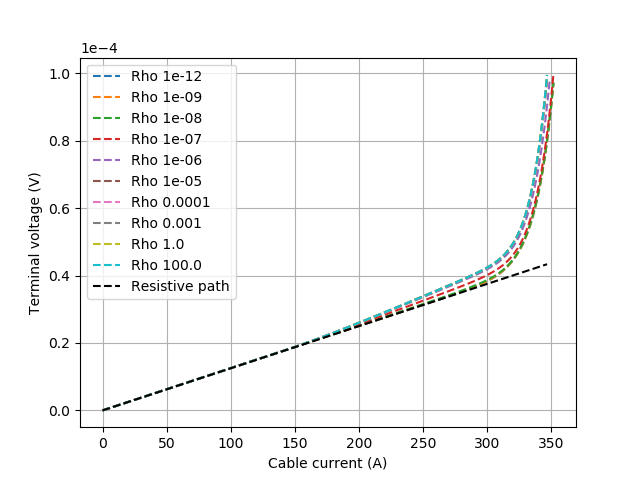

Resistance for rho 1e-09 Rc1 = 6.249999999999999e-09
Rho 1e-09: Rt = 1.251e-07, Ic = 360.5895, n = 26.2438, Fit-error = 1.758e-07

Resistance for rho 1e-08 Rc1 = 6.249999999999998e-08
Rho 1e-08: Rt = 1.258e-07, Ic = 360.6058, n = 26.2488, Fit-error = 1.2595e-06

Resistance for rho 1e-07 Rc1 = 6.249999999999998e-07
Rho 1e-07: Rt = 1.29e-07, Ic = 360.4912, n = 25.8306, Fit-error = 6.6039e-06

Resistance for rho 1e-06 Rc1 = 6.249999999999999e-06
Rho 1e-06: Rt = 1.32e-07, Ic = 358.8203, n = 24.426, Fit-error = 1.23857e-05

Resistance for rho 1e-05 Rc1 = 6.249999999999999e-05
Rho 1e-05: Rt = 1.326e-07, Ic = 356.6355, n = 24.8207, Fit-error = 1.38121e-05

Resistance for rho 0.0001 Rc1 = 0.0006249999999999999
Rho 0.0001: Rt = 1.327e-07, Ic = 356.1273, n = 25.0885, Fit-error = 1.40413e-05

Resistance for rho 0.001 Rc1 = 0.006249999999999999
Rho 0.001: Rt = 1.328e-07, Ic = 356.0709, n = 25.1205, Fit-error = 1.40664e-05

Resistance for rho 1.0 Rc1 = 6.249999999999999
Rho 1.0: Rt = 1.328e-07, Ic 

In [17]:
%matplotlib notebook

# Parameters of the tape
L = 100 # cm Length of the tape for 1 pitch length
w = 0.4 # cm Width of the tape

# Parameters for the netlist
ntapes = 4
ns = 4

Ic_mean = 100 # [A]
Ic_defect = 50 # [A]
n_mean = 30
n_defect = 15
Ic = np.zeros((ntapes,ns))+Ic_mean
Ic[2,1]= Ic_defect
n = np.zeros((ntapes,ns))+n_mean
n[2,1]= n_defect
print('Ic\n',Ic)
print('n\n',n)
Imax = ntapes*Ic_mean*1.25
print(f'Imax = {Imax}')


# Testing different contact resistivities
rhos = np.array([1E-12,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1,100])
for i in range(len(rhos)):
    
    filename = f'version2/CORC 2 layers-2 tape rho {rhos[i]}.cir'
    
    # Calculating resistances 
    rc1 = contactresistances(rhos[i],L,w)
    print(f'Resistance for rho {rhos[i]} Rc1 = {rc1}')
    
    Labels, Data_points = generatingnetlist(filename,ns,ntapes,Ic,n,rc1,Imax,L)


    data = readdata(filename,Labels,Data_points)

    Icable = data[:,1]
    Vt = data[:,2]
    #plt.plot(Icable,Vt,label = f'Rho {rhos[i]}')
    
    
    Vt_lim = []
    Icable_lim = []
    # Voltage limit
    for l in range(len(Vt)):
        if Vt[l] <= 100e-6: # Limit of the total voltage
            Vt_lim.append(Vt[l])
            Icable_lim.append(Icable[l])
    
    Vt_lim = np.array(Vt_lim)
    Icable_lim = np.array(Icable_lim)
       
    # Exponential fitting
    Rt0,Ic0,n0 = 0.5E-6,100,30 # Initial values to fit exponential part
    Rt_e,Ic_e,n_e = fit_exp(Icable_lim,Vt_lim,Rt0,Ic0,n0)
    #print(Rt_e,Ic_e,n_e)

    # Getting curve from fitting 
    Vt_fit_exp = model_func(Icable_lim,Rt_e,Ic_e,n_e)

    # Calculating fitting error
    Error = np.sqrt(sum((Vt_lim-Vt_fit_exp)**2))

    # Plotting
    print(f'Rho {rhos[i]}: Rt = {round(Rt_e,10)}, Ic = {round(Ic_e,4)}, n = {round(n_e,4)}, Fit-error = {round(Error,10)}\n')
    plt.plot(Icable_lim,Vt_lim,'--',label = f'Rho {rhos[i]}')
    #plt.plot(Icable_lim,Vt_fit_exp,label = f'Fit Rho {rhos[i]}')

plt.plot(Icable_lim,1.25E-7*Icable_lim,'--k',label='Resistive path')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Cable current (A)')
plt.ylabel('Terminal voltage (V)')
#plt.title('Terminal voltage')
#plt.ylim(0,100E-6)
#plt.xlim(0,200)
plt.grid()
plt.legend()

plt.show()
#plt.savefig(f'Plots/Terminal voltage.png')


